A mixture of $N =10$ random Gaussians centered in $[-1,1]^n$ 
$$
f(x, y) = \sum_{i=1}^10
$$
 is defined over the square $[-1, 1]^2$

In [1]:
using Globtim
include("../src/lib_func.jl") # Include the library of functions

# Constants and Parameters
d = 8 # Initial Degree 
const n, a, b = 2, 1, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 5e-4             # Define the tolerance for the L2-norm

N = 10
params = init_gaussian_params(N, .2)
# Create a closure that captures params
rand_gaussian_closure = (x) -> rand_gaussian(x, params)
f = rand_gaussian_closure; # Function to be optimized


In [2]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end;

current L2-norm: 0.005346024878303658
Number of samples: 17
current L2-norm: 0.004046206820394421
Number of samples: 21
current L2-norm: 0.002885024558238418
Number of samples: 24
current L2-norm: 0.0022842536382745604
Number of samples: 28
current L2-norm: 0.0018406207295823315
Number of samples: 31
current L2-norm: 0.0014808836798984937
Number of samples: 35
current L2-norm: 0.0012210610976491258
Number of samples: 39
current L2-norm: 0.0010218553177524362
Number of samples: 44
current L2-norm: 0.0008523727887655228
Number of samples: 48
current L2-norm: 0.0007341868809026162
Number of samples: 53
current L2-norm: 0.0006428572745153134
Number of samples: 58
current L2-norm: 0.0005503396708824851
Number of samples: 63
current L2-norm: 0.0005005164075100006
Number of samples: 68
attained the desired L2-norm: 0.00044332626574843765


In [3]:
using DynamicPolynomials, HomotopyContinuation, ProgressLogging, DataFrames
@polyvar(x[1:n]) # Define polynomial ring 
ap = main_nd(n, d, poly_approx.coeffs)
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x. 
PolynomialApproximant = sum(ap .* MonomialVector(x, 0:d))
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad)
println("The system is of degree:", d-1)

Check
The system is of degree:20


In [4]:
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false);

Computing mixed cells... 2    Time: 0:00:00
Computing mixed cells... 17    Time: 0:00:00
  mixed_volume:  400


Tracking 400 paths...   0%|▏                            |  ETA: 1:37:38



Tracking 400 paths...  26%|███████▌                     |  ETA: 0:01:28



Tracking 400 paths...  34%|█████████▊                   |  ETA: 0:01:01



Tracking 400 paths...  41%|████████████                 |  ETA: 0:00:45



Tracking 400 paths...  49%|██████████████▎              |  ETA: 0:00:33



Tracking 400 paths...  56%|████████████████▎            |  ETA: 0:00:25



Tracking 400 paths...  64%|██████████████████▌          |  ETA: 0:00:18



Tracking 400 paths...  71%|████████████████████▌        |  ETA: 0:00:13



Tracking 400 paths...  78%|██████████████████████▋      |  ETA: 0:00:09



Tracking 400 paths...  86%|█████████████████████████    |  ETA: 0:00:05



Tracking 400 paths...  94%|███████████████████████████▎ |  ETA: 0:00:02



Tracking 400 paths... 100%|█████████████████████████████| Time: 0:00:32
  # paths tracked:                  400
  # non-singular solutions (real):  400 (156)
  # singular endp

In [5]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z=h_z) # Create a DataFrame

Row,x,y,z
,Float64,Float64,Float64
1,0.807143,0.976597,0.00739726
2,0.743172,0.996002,0.00327177
3,-0.390378,-0.923702,0.00272909
4,0.321093,-0.193208,0.00983037
5,-0.927834,0.190824,1.38072e-5
6,-0.821895,-0.833962,9.07386e-8
7,-0.936819,-0.503841,1.11718e-9
8,0.994381,-0.0875667,0.238155
9,0.980784,-0.442131,0.999002


┌ Warning: attempting to remove probably stale pidfile
│   path = /home/georgy/.jlassetregistry.lock
└ @ Pidfile /home/georgy/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


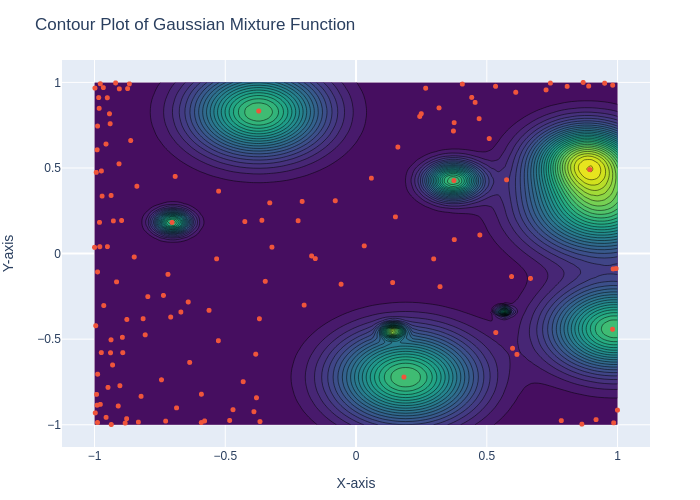

In [6]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 80  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]

# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=40, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="Contour Plot of Gaussian Mixture Function",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800 # Increase the height to make room for the legend 
)

# Display the combined plot with legend
display(plot(all_traces, layout))



In [7]:
# Optimize the collected entries 
using Optim
for i in 1:nrow(df)
    println("Optimizing for point $i")
    x0 = [df.x[i], df.y[i]]
    res = Optim.optimize(f, x0, LBFGS(), Optim.Options(show_trace=true))
    minimizer = Optim.minimizer(res)
    min_value = Optim.minimum(res)
    steps = res.iterations
    converged = Optim.converged(res)
    distance = norm(x0 - minimizer)

    # df.local_minima[i] = min_value
    # df.distance_to_minima[i] = distance
    # df.steps[i] = steps
    # df.converged[i] = converged

    println(summary(res))
end


Optimizing for point 1
Iter     Function value   Gradient norm 
     0     7.397259e-03     1.695304e-01
 * time: 0.034826040267944336
     1     0.000000e+00     0.000000e+00
 * time: 1.6824579238891602
L-BFGS
Optimizing for point 2
Iter     Function value   Gradient norm 
     0     3.271774e-03     7.805456e-02
 * time: 7.605552673339844e-5
     1     0.000000e+00     0.000000e+00
 * time: 0.0005459785461425781
L-BFGS
Optimizing for point 3
Iter     Function value   Gradient norm 
     0     2.729093e-03     4.956434e-02
 * time: 5.3882598876953125e-5
     1     0.000000e+00     0.000000e+00
 * time: 0.0004489421844482422
L-BFGS
Optimizing for point 4
Iter     Function value   Gradient norm 
     0     9.830374e-03     1.567000e-01
 * time: 1.0967254638671875e-5
     1     2.187326e-03     2.459447e-02
 * time: 0.0001990795135498047
     2     0.000000e+00     0.000000e+00
 * time: 0.0004680156707763672
L-BFGS
Optimizing for point 5
Iter     Function value   Gradient norm 
     0   

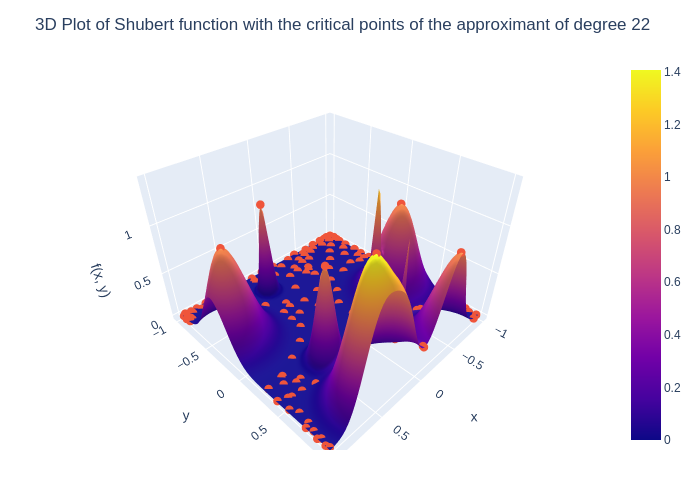

In [8]:
sf = surface(x=x, y=y, z=z)
# Had to switch the coordinates of the critical points to match the surface plot for some reason. 
crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")

# Layout for the plot
layout = Layout(title="3D Plot of Shubert function with the critical points of the approximant of degree 22",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
    height=800
)
# Display the plot layout,
plt = plot([sf, crit_pts], layout)

In [9]:
savefig(plt, "../data/figures/random_gaussian_function_plot.html")

"../data/figures/random_gaussian_function_plot.html"

Should plot the polynomial approximant too.